In [1]:
!pip install control

import control as ct
import numpy as np
import matplotlib.pyplot as plt

In [2]:

Rf = 1000 # Resistance in ohms
Cf = 50*(10**-9) # Capacitance in farads
Ci = 100*(10**-12) # Stray capacitance in farads

i_i = 0.0028 # Initial current in amperes

A0 = 10**5 # Open loop Gain of the amplifier
f0 = 100#Open loop cutoff frequency in hertz

omega0 = 2 * np.pi * f0 # Open loop cutoff frequency in radians per second

In [3]:
# Transfer function of the system
top = - A0 * omega0 /(Ci + Cf) / Rf # Topside of the transfer function
bottom = [1, (1+ omega0 * Rf * (Ci + (1+ A0)* Cf))/((Ci+Cf)*Rf), omega0*(1+A0)/((Ci+Cf)*Rf)] # Denominator of the transfer function

tf = ct.tf(top, bottom) # Transfer function of the system
print("Transfer function: ", tf)

Transfer function:  <TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


         -1.254e+12
-----------------------------
s^2 + 6.273e+07 s + 1.254e+12



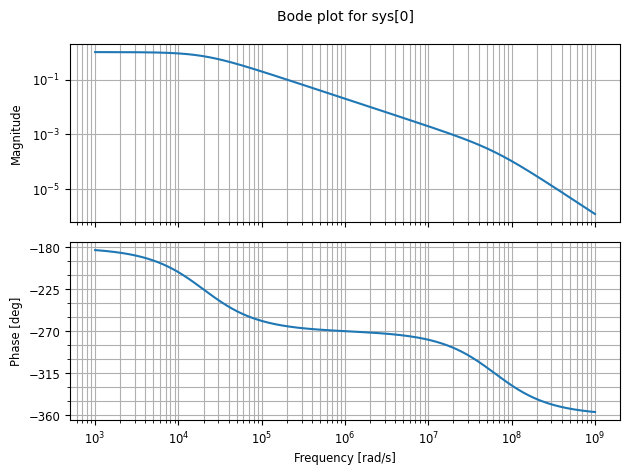

In [4]:
ct.bode(tf) # Bode plot of the transfer function
plt.show()

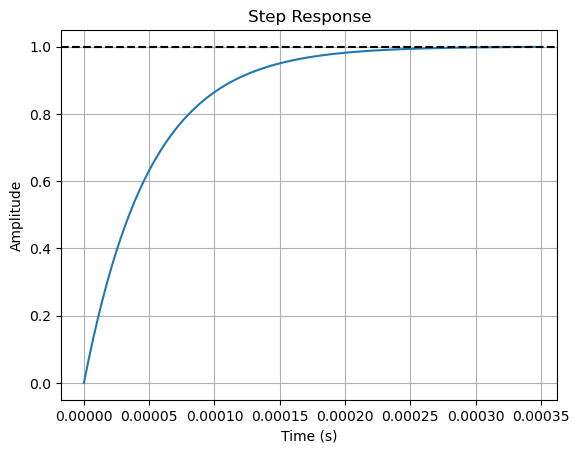

In [5]:
# t = np.linspace(0, 1, 1000) # Time vector for the step response

t, y = ct.step_response(tf ) # Step response of the system
plt.plot(t, -y) # Plotting the step response
plt.title("Step Response")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.axhline(y=1, color='k', linestyle='--')
plt.show()

In [29]:
import scipy

def sun_current_input(sun_angle_x, sun_angle_y, max_current=-2.8e-3,
                      sensor_size=5e-3, mask_distance=1.4e-3):
    """
    Generate a bunch of currents from sun angles
    """
    # Calculate illumination for each quadrant based on angles
    # Quadrants: Q1 (+x,+y), Q2 (-x,+y), Q3 (-x,-y), Q4 (+x,-y)
    # this is an AI halucinating, I will change it at some point
    dx = mask_distance * np.tan(sun_angle_x)  # X displacement [4]
    dy = mask_distance * np.tan(sun_angle_y)  # Y displacement [4]

    # Normalize displacements to sensor size [-1,1] range
    norm_x = dx / (sensor_size/2)
    norm_y = dy / (sensor_size/2)

    # Calculate illuminated area fractions for each quadrant [2][4]
    # Q1 (+x,+y), Q2 (-x,+y), Q3 (-x,-y), Q4 (+x,-y)
    area_q1 = (1 + norm_x) * (1 + norm_y) / 4
    area_q2 = (1 - norm_x) * (1 + norm_y) / 4
    area_q3 = (1 - norm_x) * (1 - norm_y) / 4
    area_q4 = (1 + norm_x) * (1 - norm_y) / 4

    # Clamp areas to [0,1] and apply cosine law for incidence angle [2]
    cos_theta = np.cos(np.sqrt(sun_angle_x**2 + sun_angle_y**2))
    i_q1 = max_current * np.clip(area_q1, 0, 1) * cos_theta
    i_q2 = max_current * np.clip(area_q2, 0, 1) * cos_theta
    i_q3 = max_current * np.clip(area_q3, 0, 1) * cos_theta
    i_q4 = max_current * np.clip(area_q4, 0, 1) * cos_theta
    return i_q1, i_q2, i_q3, i_q4

def moving_sun(t):
    # The sun is moving in circles
    x_t =  0.5 * np.cos(0.1* np.pi * t)
    y_t = 0.5 * np.sin(0.1* np.pi * t)
    return x_t, y_t

def apply_noise(voltage, offset=0.0, noise_level=0.005):
    # noise for the interested
    noise = np.random.normal(0, noise_level, size=len(voltage))
    return voltage + offset + noise

def ADC_DAC(voltage, bits, ref):
    #apply a chose bit resolution to the measurement
    #assumes a voltage floor of 0
    fraction = voltage / ref
    word = (fraction * 2**bits).astype(int)
    #Calculate the angles
    word_fraction = word/2**bits
    return word_fraction


def sun_tan_angles(Q1,Q2,Q3,Q4):
    # Calculates the sun angles
    # assumes that the maximum angle is st at 90 deg
    Q_tot = Q1+Q2+Q3+Q4
    Sa = (Q1 + Q4 - Q2 - Q3)/Q_tot
    Sb = (Q1 + Q2 - Q3 - Q4)/Q_tot
    a, b = np.arctan(Sa)*180/np.pi, np.arctan(Sb)*180/np.pi
    return a, b

def plot_angles(a, b, t):
    fig, ax = plt.subplots()


In [30]:
# Model the system after current input
time = np.linspace(0,10,1000)
x_t, y_t = moving_sun(time)
i_q1, i_q2, i_q3, i_q4 = sun_current_input(x_t, y_t)
# The output data of the response is the property y of TimeResponseData
V1, V2, V3, V4 = (ct.forced_response(tf, time, i_q1).y * Rf,
                  ct.forced_response(tf, time, i_q2).y * Rf,
                  ct.forced_response(tf, time, i_q3).y * Rf,
                  ct.forced_response(tf, time, i_q4).y * Rf)
# Calculate angles
V1_frac, V2_frac, V3_frac, V4_frac = ADC_DAC(V1, 12, 2.8), ADC_DAC(V2, 12, 2.8), ADC_DAC(V3, 12, 2.8), ADC_DAC(V4, 12, 2.8)
a, b = sun_tan_angles(Q1=V1_frac,Q2=V2_frac,Q3=V3_frac,Q4=V4_frac)

C:\Users\ebnib\AppData\Local\Temp\ipykernel_21800\169233456.py:62: RuntimeWarning: invalid value encountered in divide
  Sa = (Q1 + Q4 - Q2 - Q3)/Q_tot
C:\Users\ebnib\AppData\Local\Temp\ipykernel_21800\169233456.py:63: RuntimeWarning: invalid value encountered in divide
  Sb = (Q1 + Q2 - Q3 - Q4)/Q_tot


It would be good if the calculation included noise. For now I assume control library does this for me

before measurement: [28.64788976 28.6477481  28.64732314 28.64661487 28.64562331 28.64434846
 28.64279033 28.64094895 28.63882433 28.63641648]
after measurement: [[            nan  1.70074323e+01  1.70264782e+01  1.70074323e+01
   1.70264782e+01  1.70074323e+01  1.70074323e+01  1.70264782e+01
   1.70074323e+01  1.70264782e+01  1.70074323e+01  1.70264782e+01
   1.69973070e+01  1.69973070e+01  1.69973070e+01  1.69973070e+01
   1.69973070e+01  1.69973070e+01  1.69782633e+01  1.69973070e+01
   1.69782633e+01  1.69973070e+01  1.69782633e+01  1.69681268e+01
   1.69681268e+01  1.69681268e+01  1.69490853e+01  1.69490853e+01
   1.69490853e+01  1.69300505e+01  1.69490853e+01  1.69198982e+01
   1.69287829e+01  1.69097391e+01  1.69097391e+01  1.69097391e+01
   1.69097391e+01  1.68907020e+01  1.68907020e+01  1.68805316e+01
   1.68614968e+01  1.68614968e+01  1.68513152e+01  1.68322826e+01
   1.68322826e+01  1.68322826e+01  1.68220897e+01  1.68030594e+01
   1.68220897e+01  1.68030594e+01  1.67738271e